## Word2Vec
Since word2vec relies on predicting words by context, we do not need to eliminate stop words, since they eliminate valuable contextual information.  

In [1]:
from time import time
import gensim
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Input data
    We are taking both train and test data from kaggle, preprocessed and combined into two classes. However, a large part of the test set has no labels, which means it's not used for training/testing but may prove to be valuable to train the word2vec model. Hence, we also load the unlabelled test data to check later on in the notebook on it's effect on word2vec performance, after hyperparameter search. 

In [2]:
train_data_path = '../../data/raw_data/train.csv'
test_data_path = '../../data/raw_data/test.csv'
unlabelled_test_path = '../../data/raw_data/unlabelled_test.csv'

In [3]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
unlabelled_test = pd.read_csv(unlabelled_test_path)
print(train_data.shape)
print(test_data.shape)
print(unlabelled_test.shape)

(159571, 2)
(63978, 2)
(89186, 1)


In [4]:
comments = list(train_data['Comment'])
comments_test = list(test_data['Comment'])
unlabelled_test = list(unlabelled_test['Comment'])

In [5]:
# Assemble labels
data_label = pd.concat([train_data['Labels'], test_data['Labels']])

In [6]:
'''Simple preprocess removes common accent marks and converts the text to lowercase. 
Contrast to more advanced preprocessing techniques in tf-idf.'''
preprocessed_comments = []
for i, line in enumerate(comments):
    preprocessed_comments.append(gensim.utils.simple_preprocess(line))
for i, line in enumerate(comments_test):
    preprocessed_comments.append(gensim.utils.simple_preprocess(line))
preprocessed_comments_total = preprocessed_comments.copy()
for i, line in enumerate(unlabelled_test):
    preprocessed_comments_total.append(gensim.utils.simple_preprocess(line))
len(preprocessed_comments_total)

312735

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(preprocessed_comments, data_label , test_size = 0.15, random_state = 2, stratify=data_label)

Once we have a word2vec embedding trained, we still need to take into account multiple length comments. Because of which we cannot simply convert a paragraph to a vector embedding. However, we can take many different approaches, one of which is averaging the word vectors. 

In [8]:
def make_feature_vec(words, model, num_features, word_set):
    feature_vec = np.zeros((num_features, ), dtype="float32")
    number_of_words_added = 0

    #convert the vocabulary of the word2vec model to a set for speed
    for word in words:
        if word in word_set:
            number_of_words_added = number_of_words_added + 1
            feature_vec = np.add(feature_vec, model[word])
    
    #Normalize to 1 by dividing by length
    feature_vec = np.divide(feature_vec, number_of_words_added)
    return feature_vec

In [9]:
''' 
Convert a list of sentences (our data) to word2vec embedding
'''
def get_feature_vec_data(model, num_features, data): 
    current_count = 0
    word_set = set(model.wv.index2word)
    feature_vec_data = np.zeros((len(data), num_features), dtype="float32")
    for comment in data:         
        feature_vec_data[current_count] = make_feature_vec(comment, model, num_features, word_set)
        current_count = current_count + 1
    return feature_vec_data

In [10]:
def eval_model(num_features, min_word_count, context, downsampling, preprocessed_comments, train_label, num_epochs):
    
    start = time()
    X_train, X_test, y_train, y_test = train_test_split(preprocessed_comments, train_label, test_size = 0.176, random_state = 2)
    print("Starting to train the word2vec model.")
    num_of_workers = 6 # Number of threads to be used in parallel

    model = gensim.models.Word2Vec(
        X_train,
        size = num_features,
        window = context,
        min_count = min_word_count,
        workers = num_of_workers,
        sample = downsampling)
    
    model.train(X_train, total_examples = len(X_train), epochs=num_epochs)
    print("Training complete!")
    model.init_sims(replace=True)
    
    
    print("Extracting feature representation from word2vec model.")
    wv_data = get_feature_vec_data(model, num_features, X_train)
    wv_data = Imputer().fit_transform(wv_data)
    
    wv_test = get_feature_vec_data(model, num_features, X_test)
    wv_test = Imputer().fit_transform(wv_test)
    clf = svm.LinearSVC(dual=False, class_weight="balanced")
    print("Fitting SVM to data.")
    
    clf.fit(wv_data, y_train)

    result = clf.predict(wv_test)
    #conf_mat = confusion_matrix(test_data['Labels'], result)
    roc_auc = roc_auc_score(y_test, result, 'macro')
    end = time()
    print("The total time taken for this iteration is :", end-start)
    print("Mean AUC ROC Score is: ", roc_auc)
    return roc_auc

In [11]:
def crossval():
    # Parameters will be num_features, min_word_count, context and downsampling
    params = [[25, 3, 10, 1e-3, 10], [50, 3, 10, 1e-3, 10], [100, 3, 10, 1e-3, 10], [200, 3, 10, 1e-3, 10], [300, 3, 10, 1e-3, 10],
              [400, 3, 10, 1e-3, 10], [500, 3, 10, 1e-3, 10], [600, 3, 10, 1e-3, 10], [700, 3, 10, 1e-3, 10], 
             [300, 1, 10, 1e-3, 10], [300, 2, 10, 1e-3, 10], [300, 3, 10, 1e-3, 10], [300, 4, 10, 1e-3, 10], [300, 5, 10, 1e-3, 10],
              [300, 6, 10, 1e-3, 10], [300, 7, 10, 1e-3, 10], [300, 8, 10, 1e-3, 10], [300, 9, 10, 1e-3, 10], [300, 10, 10, 1e-3, 10],
             [300, 3, 2, 1e-3, 10], [300, 3, 4, 1e-3, 10], [300, 3, 6, 1e-3, 10], [300, 3, 8, 1e-3, 10], [300, 3, 10, 1e-3, 10],
             [300, 3, 12, 1e-3, 10], [300, 3, 14, 1e-3, 10], [300, 3, 16, 1e-3, 10], [300, 3, 18, 1e-3, 10], [300, 3, 20, 1e-3, 10],
             [300, 3, 10, 1e-1, 10], [300, 3, 10, 5e-1, 10], [300, 3, 10, 1e-2, 10], [300, 3, 10, 5e-2, 10],
              [300, 3, 10, 1e-3, 10], [300, 3, 10, 5e-3, 10], [300, 3, 10, 1e-4, 10], [300, 3, 10, 5e-4, 10],
             [300, 3, 10, 1e-1, 2], [300, 3, 10, 1e-1, 4], [300, 3, 10, 1e-1, 6], [300, 3, 10, 1e-1, 8],
             [300, 3, 10, 1e-1, 10], [300, 3, 10, 1e-1, 12], [300, 3, 10, 1e-1, 14], [300, 3, 10, 1e-1, 16], [300, 3, 10, 1e-1, 18],
             [300, 3, 10, 1e-1, 20]]
    results_roc_auc = []
    for i, param in enumerate(params):
        [num_features, min_word_count, context, downsampling, num_epochs] = param
        print("Iteration %d, Current parameters: num_features: %d, min_word_count: %d, context: %d, downsampling: %d, num_epochs: %d" % (i, num_features, min_word_count, context, downsampling, num_epochs))
        results_roc_auc.append(eval_model(num_features, min_word_count, context, downsampling, train_data, train_labels, num_epochs))
    return params[results_roc_auc.index(max(results_roc_auc))], results_roc_auc
params, results = crossval()

Iteration 0, Current parameters: num_features: 25, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 100.87986207008362
Mean AUC ROC Score is:  0.8514222860670103
Iteration 1, Current parameters: num_features: 50, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 104.23780345916748
Mean AUC ROC Score is:  0.8629761095936687
Iteration 2, Current parameters: num_features: 100, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 115.13221478462219
Mean AUC ROC Score is:  0.8729033848958342
Iteration 3, Current parameters: num_features: 200, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 138.76492500305176
Mean AUC ROC Score is:  0.8755466577193667
Iteration 4, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 156.91902947425842
Mean AUC ROC Score is:  0.878474099936879
Iteration 5, Current parameters: num_features: 400, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 175.4446303844452
Mean AUC ROC Score is:  0.8782697232491766
Iteration 6, Current parameters: num_features: 500, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 198.90626096725464
Mean AUC ROC Score is:  0.8808507364492324
Iteration 7, Current parameters: num_features: 600, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 222.25997114181519
Mean AUC ROC Score is:  0.8819975375006797
Iteration 8, Current parameters: num_features: 700, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 245.17424201965332
Mean AUC ROC Score is:  0.8823476713217724
Iteration 9, Current parameters: num_features: 300, min_word_count: 1, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 163.56704139709473
Mean AUC ROC Score is:  0.8767944893635287
Iteration 10, Current parameters: num_features: 300, min_word_count: 2, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 154.88094758987427
Mean AUC ROC Score is:  0.8759576618625721
Iteration 11, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 169.22699570655823
Mean AUC ROC Score is:  0.8777064785662171
Iteration 12, Current parameters: num_features: 300, min_word_count: 4, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 171.02924847602844
Mean AUC ROC Score is:  0.8787222769643478
Iteration 13, Current parameters: num_features: 300, min_word_count: 5, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 173.35595965385437
Mean AUC ROC Score is:  0.8782079267261547
Iteration 14, Current parameters: num_features: 300, min_word_count: 6, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 167.8551595211029
Mean AUC ROC Score is:  0.8777558361114381
Iteration 15, Current parameters: num_features: 300, min_word_count: 7, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 168.9739089012146
Mean AUC ROC Score is:  0.8758409505888746
Iteration 16, Current parameters: num_features: 300, min_word_count: 8, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 166.3850154876709
Mean AUC ROC Score is:  0.8802385973215067
Iteration 17, Current parameters: num_features: 300, min_word_count: 9, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 164.35562443733215
Mean AUC ROC Score is:  0.8780570754877642
Iteration 18, Current parameters: num_features: 300, min_word_count: 10, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 167.2165253162384
Mean AUC ROC Score is:  0.8753902492755216
Iteration 19, Current parameters: num_features: 300, min_word_count: 3, context: 2, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 157.97499632835388
Mean AUC ROC Score is:  0.8755203257279291
Iteration 20, Current parameters: num_features: 300, min_word_count: 3, context: 4, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 156.95910024642944
Mean AUC ROC Score is:  0.8778734735860447
Iteration 21, Current parameters: num_features: 300, min_word_count: 3, context: 6, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 159.57936549186707
Mean AUC ROC Score is:  0.877539946646844
Iteration 22, Current parameters: num_features: 300, min_word_count: 3, context: 8, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 160.17625164985657
Mean AUC ROC Score is:  0.879504652815083
Iteration 23, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 168.2773778438568
Mean AUC ROC Score is:  0.8772234896899896
Iteration 24, Current parameters: num_features: 300, min_word_count: 3, context: 12, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 173.77556085586548
Mean AUC ROC Score is:  0.8766736101857401
Iteration 25, Current parameters: num_features: 300, min_word_count: 3, context: 14, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 183.59684586524963
Mean AUC ROC Score is:  0.8769748495620664
Iteration 26, Current parameters: num_features: 300, min_word_count: 3, context: 16, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 188.0512237548828
Mean AUC ROC Score is:  0.8748616076577096
Iteration 27, Current parameters: num_features: 300, min_word_count: 3, context: 18, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 204.63461017608643
Mean AUC ROC Score is:  0.8790913331696049
Iteration 28, Current parameters: num_features: 300, min_word_count: 3, context: 20, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 212.00046730041504
Mean AUC ROC Score is:  0.8757284072192679
Iteration 29, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 236.820298910141
Mean AUC ROC Score is:  0.8802708848843812
Iteration 30, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 228.51112627983093
Mean AUC ROC Score is:  0.8790876283659685
Iteration 31, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 215.8206844329834
Mean AUC ROC Score is:  0.8787047438815467
Iteration 32, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 228.32095336914062
Mean AUC ROC Score is:  0.8781899305428992
Iteration 33, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 180.05685949325562
Mean AUC ROC Score is:  0.8778411860231703
Iteration 34, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 207.31279277801514
Mean AUC ROC Score is:  0.879437762187061
Iteration 35, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 151.3936471939087
Mean AUC ROC Score is:  0.8775380942450258
Iteration 36, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 158.1520140171051
Mean AUC ROC Score is:  0.8771589145642404
Iteration 37, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 2
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 143.2447509765625
Mean AUC ROC Score is:  0.8765426075324235
Iteration 38, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 4
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 160.76204872131348
Mean AUC ROC Score is:  0.8777226223476544
Iteration 39, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 6
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 171.2938311100006
Mean AUC ROC Score is:  0.8798220359728466
Iteration 40, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 8
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 187.08768963813782
Mean AUC ROC Score is:  0.8769217872132088
Iteration 41, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 10
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 211.06814551353455
Mean AUC ROC Score is:  0.8764572576206915
Iteration 42, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 12
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 218.24424481391907
Mean AUC ROC Score is:  0.8791554451948996
Iteration 43, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 14
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 255.4501507282257
Mean AUC ROC Score is:  0.8779039087471011
Iteration 44, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 16
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 290.1234972476959
Mean AUC ROC Score is:  0.8798058921914093
Iteration 45, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 18
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 312.5202491283417
Mean AUC ROC Score is:  0.8786710670173083
Iteration 46, Current parameters: num_features: 300, min_word_count: 3, context: 10, downsampling: 0, num_epochs: 20
Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 329.10125279426575
Mean AUC ROC Score is:  0.8790069094587818


In [16]:
results

[0.8514222860670103,
 0.8629761095936687,
 0.8729033848958342,
 0.8755466577193667,
 0.878474099936879,
 0.8782697232491766,
 0.8808507364492324,
 0.8819975375006797,
 0.8823476713217724,
 0.8767944893635287,
 0.8759576618625721,
 0.8777064785662171,
 0.8787222769643478,
 0.8782079267261547,
 0.8777558361114381,
 0.8758409505888746,
 0.8802385973215067,
 0.8780570754877642,
 0.8753902492755216,
 0.8755203257279291,
 0.8778734735860447,
 0.877539946646844,
 0.879504652815083,
 0.8772234896899896,
 0.8766736101857401,
 0.8769748495620664,
 0.8748616076577096,
 0.8790913331696049,
 0.8757284072192679,
 0.8802708848843812,
 0.8790876283659685,
 0.8787047438815467,
 0.8781899305428992,
 0.8778411860231703,
 0.879437762187061,
 0.8775380942450258,
 0.8771589145642404,
 0.8765426075324235,
 0.8777226223476544,
 0.8798220359728466,
 0.8769217872132088,
 0.8764572576206915,
 0.8791554451948996,
 0.8779039087471011,
 0.8798058921914093,
 0.8786710670173083,
 0.8790069094587818]

## Note
The graphs are quite noisy since I did not use k-fold cross-validation. Doing so, would have taken over 1 day to finish running the code. 

Text(0.5, 0, 'Epochs')

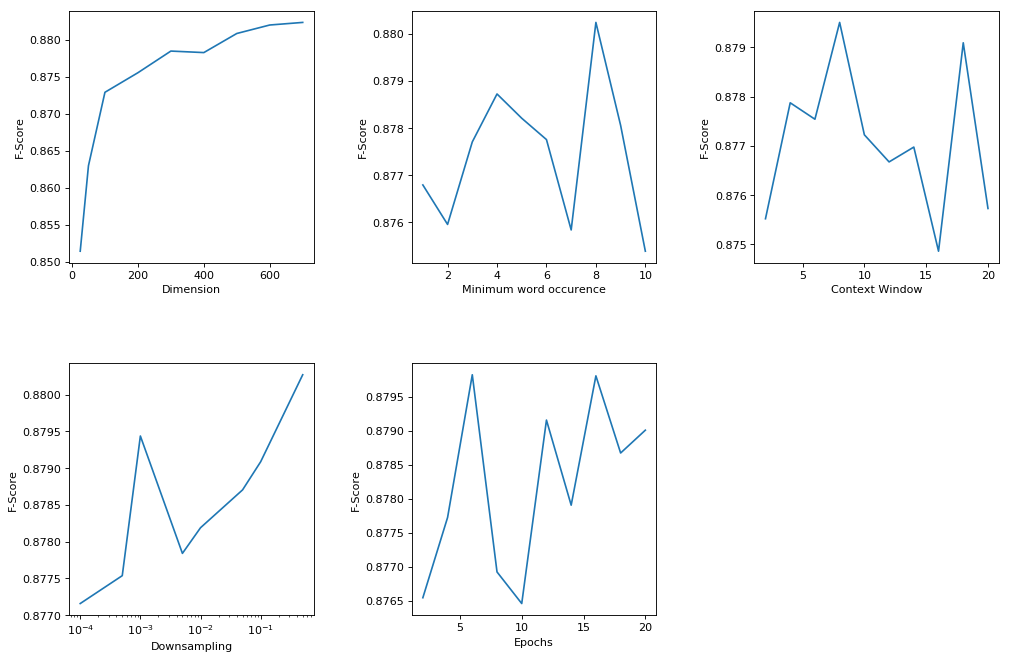

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15, 10), dpi=80)
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
plt.subplot(2,3,1)
plt.plot([25, 50, 100, 200, 300, 400, 500, 600, 700] ,results[0:9])
#plt.ylim((0.54, 0.7))
plt.ylabel("F-Score")
plt.xlabel("Dimension")
plt.subplot(2, 3, 2)
#plt.ylim((0.6, 0.7))
plt.plot([1, 2,3,4,5,6,7,8,9,10] ,results[9:19])
plt.ylabel("F-Score")
plt.xlabel("Minimum word occurence")
plt.subplot(2, 3, 3)
#plt.ylim((0.6, 0.7))
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20] ,results[19:29])
plt.ylabel("F-Score")
plt.xlabel("Context Window")
plt.subplot(2, 3, 4)
#plt.ylim((0.6, 0.7))
reorder = [results[30], results[29], results[31]]
plt.semilogx([5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4] ,results[29:37])
plt.ylabel("F-Score")
plt.xlabel("Downsampling")
plt.subplot(2, 3, 5)
#plt.ylim((0.6, 0.7))
plt.plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20] ,results[37:47])
plt.ylabel("F-Score")
plt.xlabel("Epochs")

In [18]:
params

[700, 3, 10, 0.001, 10]

In [19]:
eval_model(params[0], params[1], params[2], params[3], train_data, train_labels, params[4])

Starting to train the word2vec model.
Training complete!
Extracting feature representation from word2vec model.


C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Abhay\Anaconda3\envs\toxic-comments\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
C:\Users\Abhay\Anaconda3\envs\toxic-c

Fitting SVM to data.
The total time taken for this iteration is : 247.24650716781616
Mean AUC ROC Score is:  0.8819980006011343


0.8819980006011343

In [21]:
print("Final parameters are: Dimensions %d, Min Word Occurence %d, Context Window %d, Downsampling %0.3f, Epochs %d. " % (300, 3, 10, 1e-3, 10))

Final parameters are: Dimensions 300, Min Word Occurence 3, Context Window 10, Downsampling 0.001, Epochs 10. 
